# Prova – Projetista de Sistemas Embarcados ML (Mobit)

- Q1: OpenCV (contagem por contornos)
- Q2.1: YOLOv8 (contagem de pessoas)
- Q2.2: Classificador BMW-10 (3,4,5 e Outros) com ResNet18

In [ ]:
!pip -q install ultralytics opencv-python scipy scikit-learn matplotlib torch torchvision

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)
print("OK: deps + outputs/")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s eta 0:00:00
OK: deps + outputs/


In [8]:
Q1_IMAGE_PATH  = "/content/graos.jpg"       # imagem dos grãos
Q21_IMAGE_PATH = "/content/person.jpg"      # imagem pra YOLO (pessoas)

## Q1 — OpenCV (Contagem de objetos)

Objetos: 88


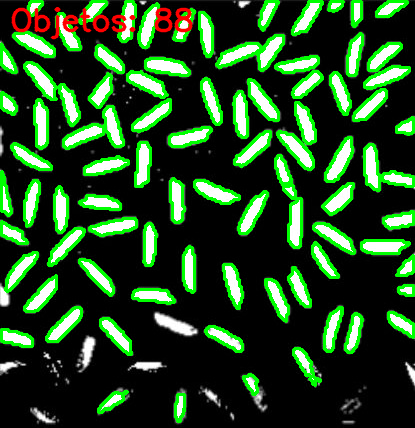

In [ ]:
from google.colab.patches import cv2_imshow

# ============================================================
# CONTAGEM DE OBJETOS (GRÃOS) COM SEPARAÇÃO DE OBJETOS COLADOS
# Técnica: Threshold (OTSU) + Morfologia + Distance Transform + Watershed
# Depois: filtro por área e solidez para remover ruídos/artefatos.
# ============================================================

# ---------- 1) LEITURA DA IMAGEM ----------
img = cv2.imread(Q1_IMAGE_PATH)
if img is None:
    raise FileNotFoundError("Imagem não encontrada. Verifique o caminho em Q1_IMAGE_PATH.")

orig = img.copy()  # cópia para desenhar o resultado no final

# ---------- 2) PRÉ-PROCESSAMENTO (CINZA + SUAVIZAÇÃO) ----------
# Converte para tons de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Suaviza com Gaussiano para reduzir ruído antes do threshold
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# ---------- 3) BINARIZAÇÃO (THRESHOLD OTSU) ----------
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ---------- 4) LIMPEZA MORFOLÓGICA ----------
kernel = np.ones((3, 3), np.uint8)

# Opening: remove ruído
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Closing: fecha pequenos "buracos" nos grãos
opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)

# ---------- 5) PREPARAR PARA WATERSHED ----------
# sure_bg = fundo “com certeza”
# dilatação aumenta o fundo preto ao redor, ajudando a definir bordas
sure_bg = cv2.dilate(opening, kernel, iterations=2)

# distance transform: cria um "mapa" onde o centro do grão tem valor alto
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# sure_fg = “sementes” (núcleos) dos grãos
# fg_factor controla o quão “pequenas” são as sementes:
# - maior -> sementes menores (tende a separar melhor colados, mas pode perder alguns)
# - menor -> sementes maiores (tende a juntar colados)
fg_factor = 0.55
_, sure_fg = cv2.threshold(dist, fg_factor * dist.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

# unknown = região que não sabemos se é fundo ou objeto
unknown = cv2.subtract(sure_bg, sure_fg)

# ---------- 6) MARCADORES PARA O WATERSHED ----------
# Rotula cada “semente” como um objeto diferente
num_labels, markers = cv2.connectedComponents(sure_fg)

# Ajustes exigidos pelo watershed:
# - fundo não pode ser 0 (o 0 é reservado para "unknown")
markers = markers + 1
markers[unknown == 255] = 0

# Watershed separa objetos colados com base nos marcadores
markers_ws = cv2.watershed(img, markers)
# Observação: watershed marca bordas com -1 (inclui borda externa da imagem)

# ---------- 7) FILTRO DOS SEGMENTOS (REMOVE SUJEIRA / ARTEFATOS) ----------
# Aqui filtramos os segmentos gerados pelo watershed:
# - área: remove pontinhos e coisas muito grandes
# - solidez: remove blobs “recortados”/irregulares (sujeira típica)

A_MIN   = 100
A_MAX   = 1300
SOL_MIN = 0.70

labels = np.unique(markers_ws)
valid_labels = []

for lab in labels:
    # lab <= 1:
    # -1 = borda watershed
    #  0 = unknown
    #  1 = fundo
    if lab <= 1:
        continue

    # máscara binária do segmento atual
    mask = (markers_ws == lab).astype(np.uint8) * 255

    # pega o contorno desse segmento
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        continue

    c = max(cnts, key=cv2.contourArea)

    # ---- filtro 1: área ----
    area = cv2.contourArea(c)
    if not (A_MIN <= area <= A_MAX):
        continue

    # ---- filtro 2: solidez ----
    # solidez = area / area_do_convex_hull
    # grão “bom” tende a ser mais “cheio”; sujeira irregular tende a ser menos sólida
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    if hull_area == 0:
        continue

    solidity = area / hull_area
    if solidity < SOL_MIN:
        continue

    valid_labels.append(lab)

print(f"Objetos: {len(valid_labels)}")

# ---------- 8) DESENHO DO RESULTADO FINAL ----------
out = orig.copy()

for lab in valid_labels:
    mask = (markers_ws == lab).astype(np.uint8) * 255
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(out, cnts, -1, (0, 255, 0), 2)

cv2.putText(out, f"Objetos: {len(valid_labels)}", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

cv2_imshow(out)

## Q2.1 — YOLOv8 (Contagem de pessoas)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Pessoas detectadas: 7


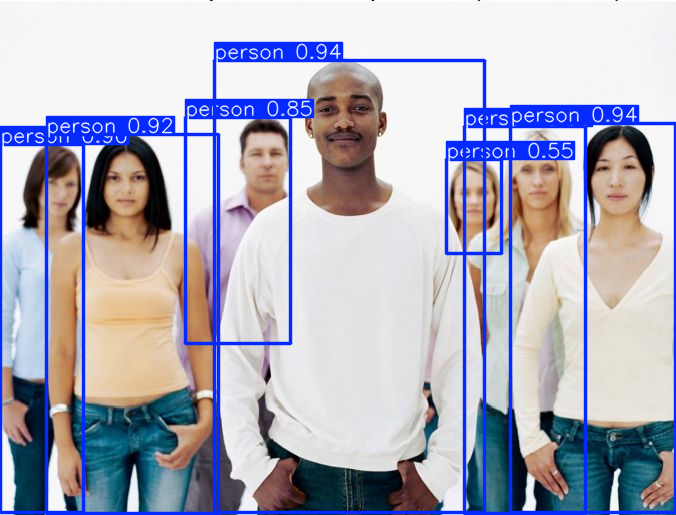

In [9]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# 1) Carregar o modelo pré-treinado (COCO)
model = YOLO("yolov8s.pt")

# 2) Ler a imagem
img = cv2.imread(Q21_IMAGE_PATH)
if img is None:
    raise FileNotFoundError("Não foi possível abrir 'person.jpg'. Verifique o nome/caminho.")

# 3) Inferência com model.predict()
# conf = limiar de confiança
results = model.predict(source=img, conf=0.40, iou=0.45, imgsz=640, verbose=False)

# 4) Contar quantas detecções são 'person'
# No COCO, 'person' é class_id = 0
r = results[0]
classes = r.boxes.cls.cpu().numpy().astype(int)  # array de class_ids
person_count = int(np.sum(classes == 0))

print(f"Pessoas detectadas: {person_count}")

# 5) Mostrar imagem anotada
annotated = r.plot()  # retorna imagem BGR com boxes/labels desenhados
cv2_imshow(annotated)

## Q2.2 — Classificador BMW-10 (3,4,5 e Outros)